In [ ]:
# I downloaded and unzip dataset, overwrite existing files
!wget -O bike_sharing_dataset.zip https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
!unzip -o bike_sharing_dataset.zip

--2024-12-02 20:06:35--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike_sharing_dataset.zip’

bike_sharing_datase     [ <=>                ] 273.43K  --.-KB/s    in 0.1s    

2024-12-02 20:06:36 (2.15 MB/s) - ‘bike_sharing_dataset.zip’ saved [279992]

Archive:  bike_sharing_dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.font_manager as fm
import warnings
from sklearn.linear_model import LinearRegression, Ridge, Lasso


In [ ]:
# Loaded dataset
data = pd.read_csv('day.csv')

In [ ]:
print(data.shape)

(731, 16)


In [ ]:
data.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [ ]:
print(data.duplicated().sum())

0


[link text](https://)# Data Preparation

In [ ]:
# Convert 'dteday' to datetime and extract date-based features , it was an object
data['dteday'] = pd.to_datetime(data['dteday'])
data['year'] = data['dteday'].dt.year
data['month'] = data['dteday'].dt.month
data['is_weekend'] = data['weekday'].apply(lambda x: 1 if x in [0, 6] else 0)

In [ ]:
data[['dteday', 'year', 'month', 'is_weekend']]

dteday  year  month  is_weekend
0   2011-01-01  2011      1           1
1   2011-01-02  2011      1           1
2   2011-01-03  2011      1           0
3   2011-01-04  2011      1           0
4   2011-01-05  2011      1           0
..         ...   ...    ...         ...
726 2012-12-27  2012     12           0
727 2012-12-28  2012     12           0
728 2012-12-29  2012     12           1
729 2012-12-30  2012     12           1
730 2012-12-31  2012     12           0

[731 rows x 4 columns]

In [ ]:
# One-hot encode categorical columns as we work with numerical data
categorical_cols = ['season', 'holiday', 'weekday', 'weathersit']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True,dtype=int)

In [ ]:
data_encoded

instant     dteday  yr  mnth  workingday      temp     atemp       hum  \
0          1 2011-01-01   0     1           0  0.344167  0.363625  0.805833   
1          2 2011-01-02   0     1           0  0.363478  0.353739  0.696087   
2          3 2011-01-03   0     1           1  0.196364  0.189405  0.437273   
3          4 2011-01-04   0     1           1  0.200000  0.212122  0.590435   
4          5 2011-01-05   0     1           1  0.226957  0.229270  0.436957   
..       ...        ...  ..   ...         ...       ...       ...       ...   
726      727 2012-12-27   1    12           1  0.254167  0.226642  0.652917   
727      728 2012-12-28   1    12           1  0.253333  0.255046  0.590000   
728      729 2012-12-29   1    12           0  0.253333  0.242400  0.752917   
729      730 2012-12-30   1    12           0  0.255833  0.231700  0.483333   
730      731 2012-12-31   1    12           1  0.215833  0.223487  0.577500   

     windspeed  casual  ...  season_4  holiday_1  weekday_1  weekday_2  \
0     0.160446     331  ...         0          0          0          0   
1     0.248539     131  ...         0          0          0          0   
2     0.248309     120  ...         0          0          1          0   
3     0.160296     108  ...         0          0          0          1   
4     0.186900      82  ...         0          0          0          0   
..         ...     ...  ...       ...        ...        ...        ...   
726   0.350133     247  ...         0          0          0          0   
727   0.155471     644  ...         0          0          0          0   
728   0.124383     159  ...         0          0          0          0   
729   0.350754     364  ...         0          0          0          0   
730   0.154846     439  ...         0          0          1          0   

     weekday_3  weekday_4  weekday_5  weekday_6  weathersit_2  weathersit_3  
0            0          0          0          1             1             0  
1            0          0          0          0             1             0  
2            0          0          0          0             0             0  
3            0          0          0          0             0             0  
4            1          0          0          0             0             0  
..         ...        ...        ...        ...           ...           ...  
726          0          1          0          0             1             0  
727          0          0          1          0             1             0  
728          0          0          0          1             1             0  
729          0          0          0          0             0             0  
730          0          0          0          0             1             0  

[731 rows x 27 columns]

In [ ]:
# Normalize continuous columns better in modelling
scaler = MinMaxScaler()
continuous_cols = ['temp', 'atemp', 'hum', 'windspeed']
data_encoded[continuous_cols] = scaler.fit_transform(data_encoded[continuous_cols])


In [ ]:
data_encoded[continuous_cols]

temp     atemp       hum  windspeed
0    0.355170  0.373517  0.828620   0.284606
1    0.379232  0.360541  0.715771   0.466215
2    0.171000  0.144830  0.449638   0.465740
3    0.175530  0.174649  0.607131   0.284297
4    0.209120  0.197158  0.449313   0.339143
..        ...       ...       ...        ...
726  0.243025  0.193709  0.671380   0.675656
727  0.241986  0.230993  0.606684   0.274350
728  0.241986  0.214393  0.774208   0.210260
729  0.245101  0.200348  0.497001   0.676936
730  0.195259  0.189567  0.593830   0.273062

[731 rows x 4 columns]

In [ ]:
print("Missing values in each column:")
print(data_encoded.isnull().sum())

Missing values in each column:
instant         0
dteday          0
yr              0
mnth            0
workingday      0
temp            0
atemp           0
hum             0
windspeed       0
casual          0
registered      0
cnt             0
year            0
month           0
is_weekend      0
season_2        0
season_3        0
season_4        0
holiday_1       0
weekday_1       0
weekday_2       0
weekday_3       0
weekday_4       0
weekday_5       0
weekday_6       0
weathersit_2    0
weathersit_3    0
dtype: int64


**EDA Visualization:**

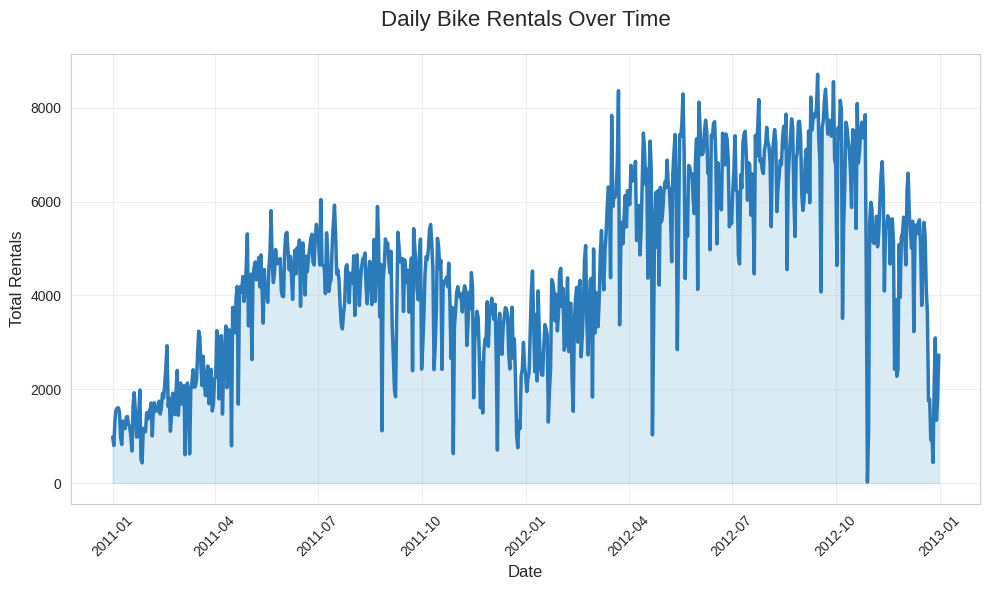

In [ ]:
# Set the general style
sns.set_style("whitegrid")

# Set font to Liberation Sans explicitly
plt.rcParams['font.family'] = 'Liberation Sans'

# Create season and weather mappings
season_names = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
weather_names = {
    1: 'Clear',
    2: 'Mist + Cloudy',
    3: 'Light Rain/Snow',
    4: 'Heavy Rain + Storm'
}

# Map season and weather names
data_mapped = data.copy()
data_mapped['season_name'] = data_mapped['season'].map(season_names)
data_mapped['weather_name'] = data_mapped['weathersit'].map(weather_names)


def plot_daily_rentals(data):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("Blues", n_colors=6)
    plt.plot(data['dteday'], data['cnt'], color=palette[4], linewidth=2.5)
    plt.fill_between(data['dteday'], data['cnt'], alpha=0.3, color=palette[2])
    plt.title('Daily Bike Rentals Over Time', fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Total Rentals', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
data['season_name'] = data['season'].map(season_names)
data['weather_name'] = data['weathersit'].map(weather_names)


plot_daily_rentals(data)

<ipython-input-17-bf8fe38c0882>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='mnth', y='cnt', data=data, palette='Blues')


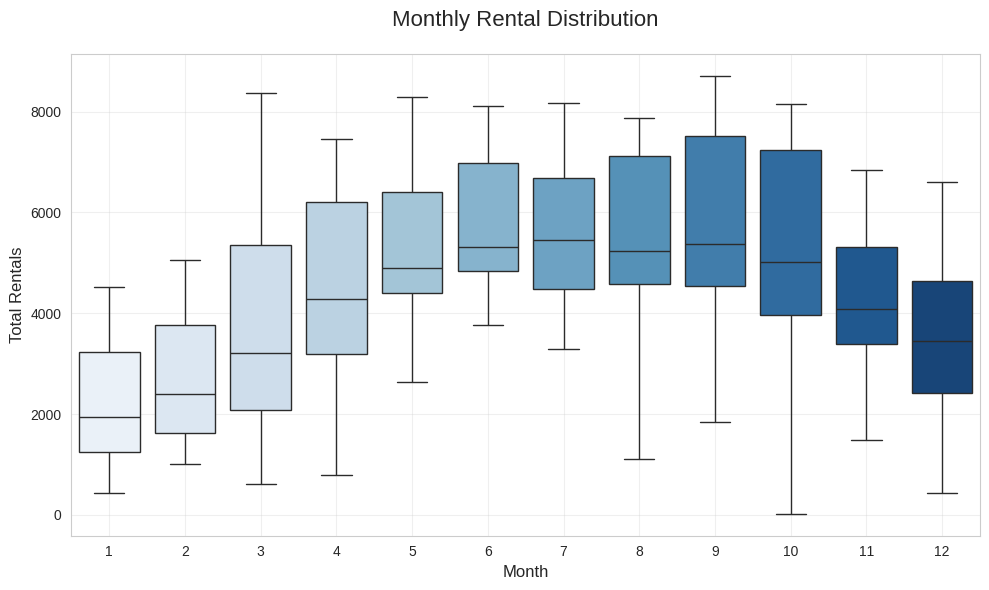

In [ ]:
def plot_monthly_boxplot(data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='mnth', y='cnt', data=data, palette='Blues')
    plt.title('Monthly Rental Distribution', fontsize=16, pad=20)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Total Rentals', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_monthly_boxplot(data)

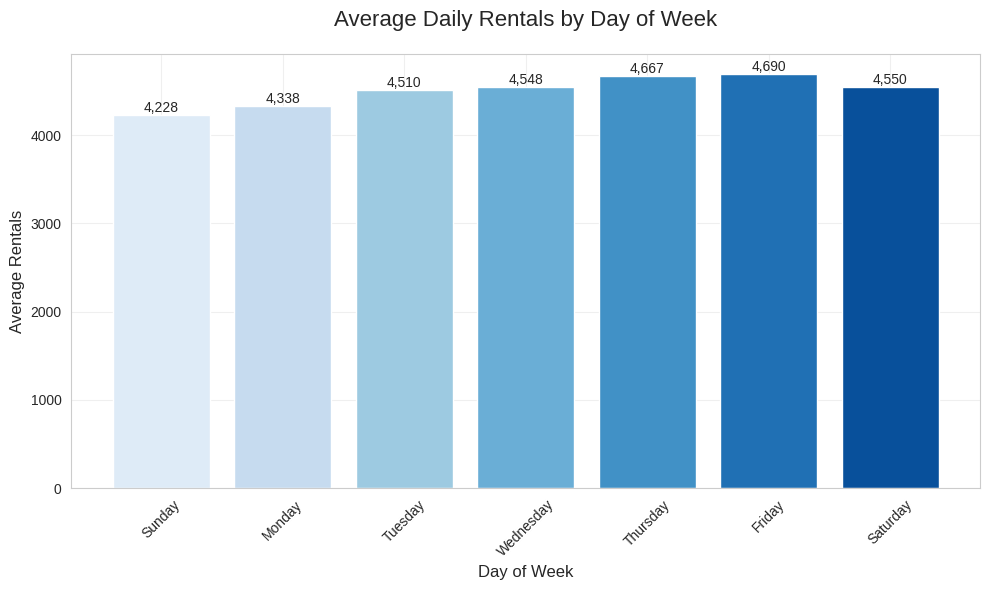

In [ ]:
def plot_weekly_avg_rentals(data):
    plt.figure(figsize=(10, 6))
    weekly_avg = data.groupby('weekday')['cnt'].mean()
    days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    palette = sns.color_palette("Blues", n_colors=len(days))
    bars = plt.bar(days, weekly_avg, color=palette)
    plt.title('Average Daily Rentals by Day of Week', fontsize=16, pad=20)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Average Rentals', fontsize=12)
    plt.xticks(rotation=45)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{int(height):,}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_weekly_avg_rentals(data)

<Figure size 1000x600 with 0 Axes>

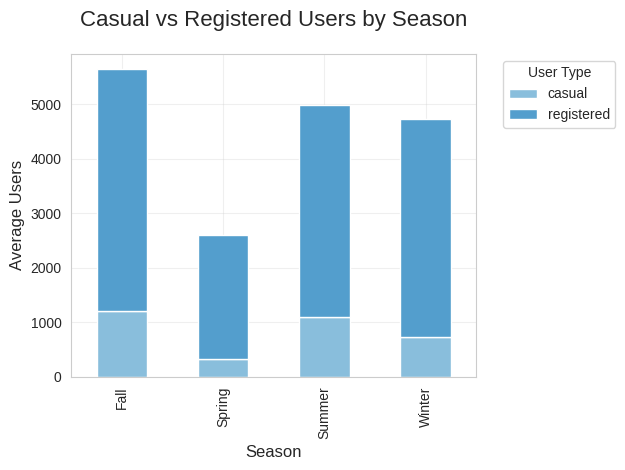

In [ ]:
def plot_casual_vs_registered(data):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("Blues", n_colors=6)
    seasonal_data = data.groupby('season_name')[['casual', 'registered']].mean()
    seasonal_data.plot(kind='bar', stacked=True, color=palette[2:4])
    plt.title('Casual vs Registered Users by Season', fontsize=16, pad=20)
    plt.xlabel('Season', fontsize=12)
    plt.ylabel('Average Users', fontsize=12)
    plt.legend(title='User Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_casual_vs_registered(data)

<ipython-input-20-3cb7f717446a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weather_name', y='cnt', data=average_rentals, palette='Blues')


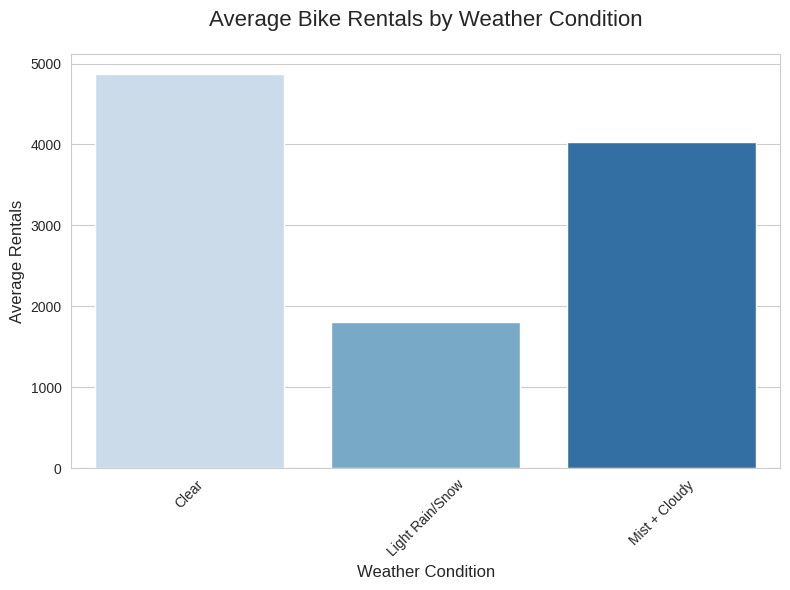

In [ ]:
def plot_weather_impact(data):
    plt.figure(figsize=(8, 6))
    average_rentals = data.groupby('weather_name')['cnt'].mean().reset_index()
    sns.barplot(x='weather_name', y='cnt', data=average_rentals, palette='Blues')
    plt.title('Average Bike Rentals by Weather Condition', fontsize=16, pad=20)
    plt.xlabel('Weather Condition', fontsize=12)
    plt.ylabel('Average Rentals', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_weather_impact(data)

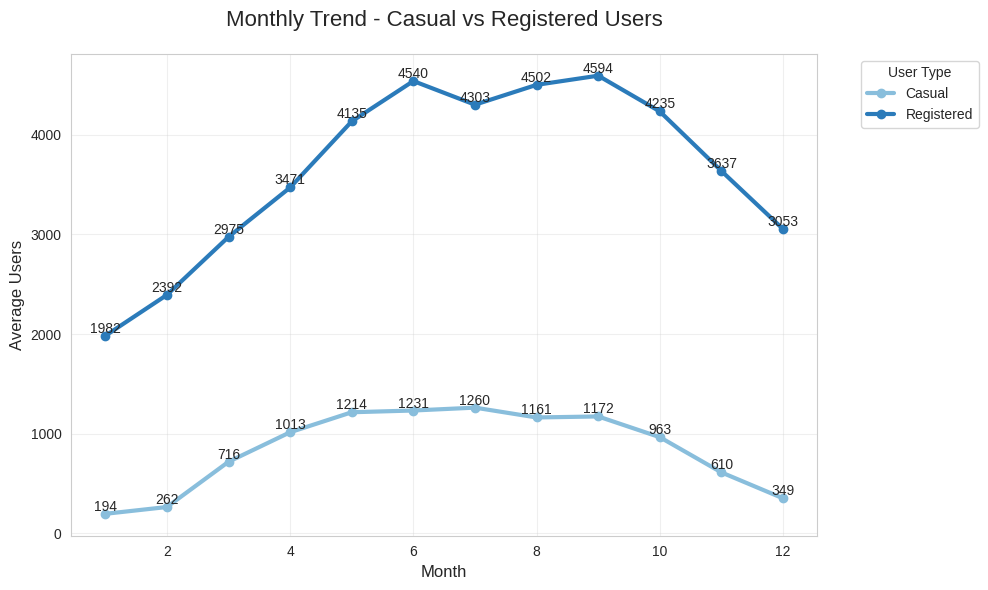

In [ ]:
def plot_monthly_trend(data):
    plt.figure(figsize=(10, 6))
    monthly_data = data.groupby('mnth')[['casual', 'registered']].mean()
    palette = sns.color_palette("Blues", n_colors=6)

    plt.plot(monthly_data.index, monthly_data['casual'], 'o-',
             color=palette[2], linewidth=3, label='Casual')
    plt.plot(monthly_data.index, monthly_data['registered'], 'o-',
             color=palette[4], linewidth=3, label='Registered')

    plt.title('Monthly Trend - Casual vs Registered Users', fontsize=16, pad=20)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Users', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='User Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add value labels
    for i in monthly_data.index:
        plt.text(i, monthly_data['casual'][i], f'{int(monthly_data["casual"][i])}',
                 ha='center', va='bottom')
        plt.text(i, monthly_data['registered'][i], f'{int(monthly_data["registered"][i])}',
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
plot_monthly_trend(data)

In [ ]:
def print_enhanced_summary(data):
    # Create season and weather mappings
    season_names = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
    weather_names = {
        1: 'Clear, Few clouds, Partly cloudy',
        2: 'Mist + Cloudy, Mist + Broken clouds',
        3: 'Light Snow, Light Rain + Scattered clouds',
        4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist'
    }

    print("\n📊 Bike Rental Analysis Summary")
    print("=" * 50)

    # Overall statistics
    print("\n📈 Overall Statistics")
    print("-" * 30)
    print(f"Total Rentals: {data['cnt'].sum():,}")
    print(f"Average Daily Rentals: {data['cnt'].mean():,.0f}")
    print(f"Maximum Daily Rentals: {data['cnt'].max():,}")
    print(f"Minimum Daily Rentals: {data['cnt'].min():,}")

    # Seasonal analysis
    print("\n🌤 Seasonal Analysis")
    print("-" * 30)
    seasonal_avg = data.groupby('season')['cnt'].mean()
    for season, avg in seasonal_avg.items():
        print(f"{season_names[season]}: {avg:,.0f} rentals")

    # User type distribution
    print("\n👥 User Distribution")
    print("-" * 30)
    total_users = data['casual'].sum() + data['registered'].sum()
    casual_percentage = (data['casual'].sum() / total_users) * 100
    registered_percentage = (data['registered'].sum() / total_users) * 100

    print(f"Casual Users: {casual_percentage:.1f}%")
    print(f"Registered Users: {registered_percentage:.1f}%")

    # Weather impact
    print("\n🌦 Weather Impact")
    print("-" * 30)
    weather_avg = data.groupby('weathersit')['cnt'].mean()
    for weather, avg in weather_avg.items():
        print(f"{weather_names[weather]}: {avg:,.0f} average rentals")
print_enhanced_summary(data)



📊 Bike Rental Analysis Summary

📈 Overall Statistics
------------------------------
Total Rentals: 3,292,679
Average Daily Rentals: 4,504
Maximum Daily Rentals: 8,714
Minimum Daily Rentals: 22

🌤 Seasonal Analysis
------------------------------
Spring: 2,604 rentals
Summer: 4,992 rentals
Fall: 5,644 rentals
Winter: 4,728 rentals

👥 User Distribution
------------------------------
Casual Users: 18.8%
Registered Users: 81.2%

🌦 Weather Impact
------------------------------
Clear, Few clouds, Partly cloudy: 4,877 average rentals
Mist + Cloudy, Mist + Broken clouds: 4,036 average rentals
Light Snow, Light Rain + Scattered clouds: 1,803 average rentals


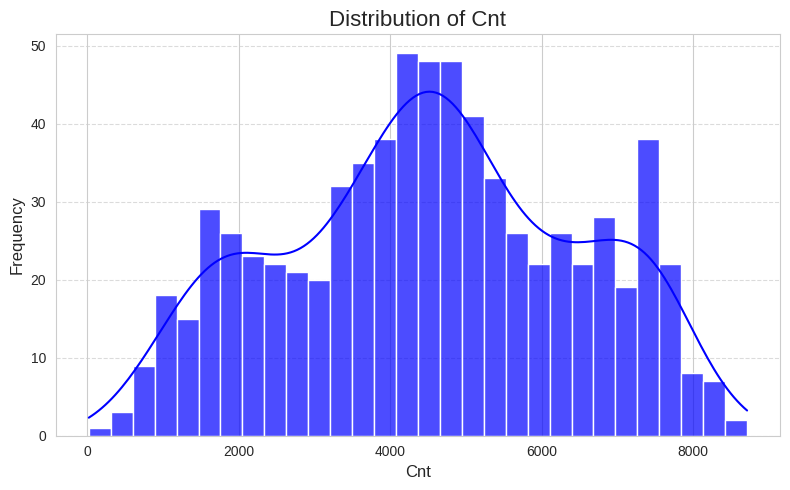

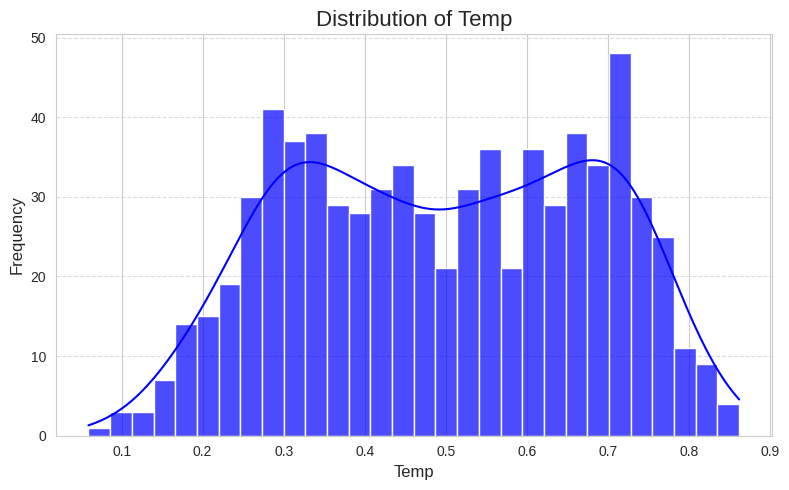

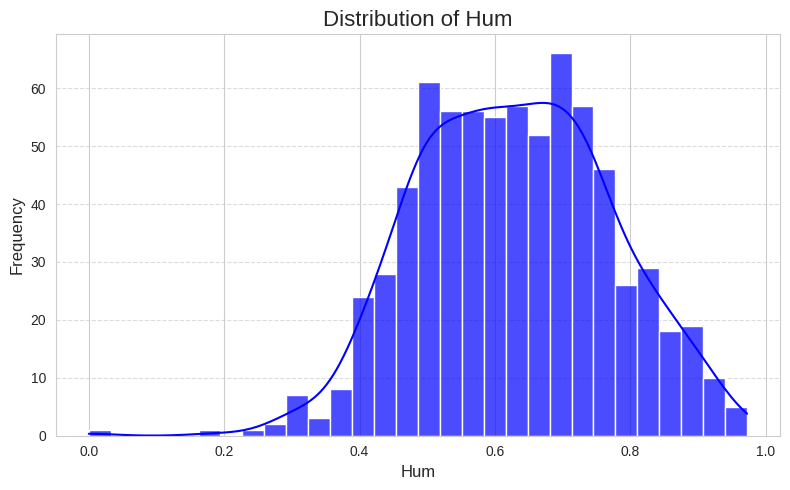

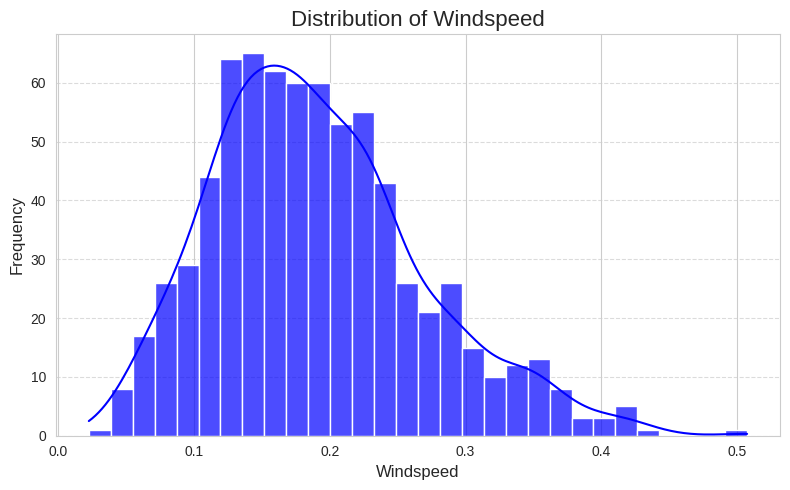

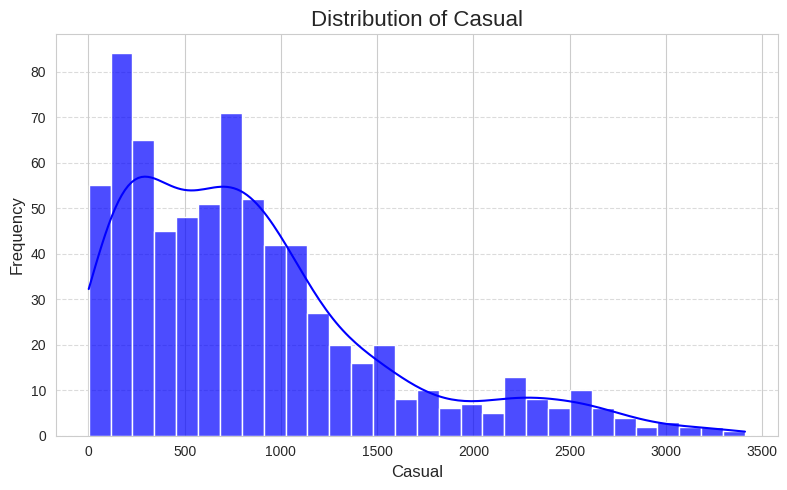

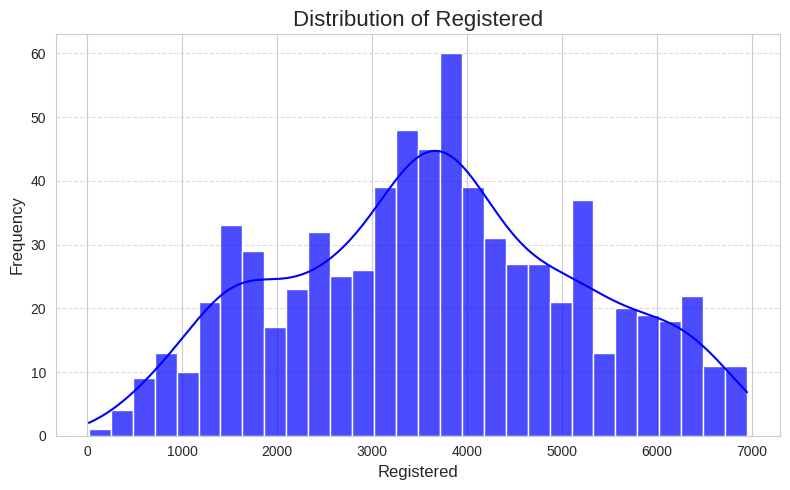

In [ ]:
# List of features for distribution plots
features_to_plot = ['cnt', 'temp', 'hum', 'windspeed', 'casual', 'registered']

# Plot distributions for each feature
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[feature], kde=True, bins=30, color='blue', alpha=0.7)
    plt.title(f"Distribution of {feature.capitalize()}", fontsize=16)
    plt.xlabel(feature.capitalize(), fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


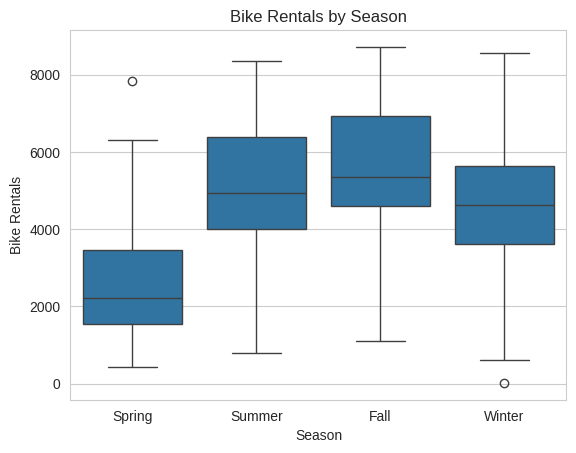

In [ ]:
# Define season names
season_names = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}

# Map season numbers to season names
data['season_name'] = data['season'].map(season_names)

# Create the boxplot with season names on the x-axis
sns.boxplot(x='season_name', y='cnt', data=data)
plt.title("Bike Rentals by Season")
plt.xlabel("Season")
plt.ylabel("Bike Rentals")
plt.show()


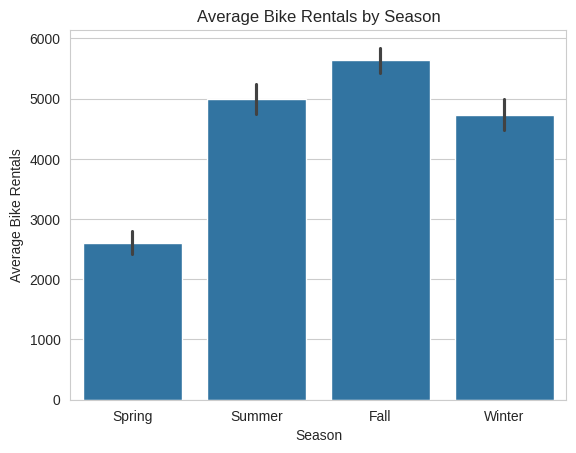

In [ ]:

# Create the barplot with season names on the x-axis
sns.barplot(x='season_name', y='cnt', data=data)
plt.title("Average Bike Rentals by Season")
plt.xlabel("Season")
plt.ylabel("Average Bike Rentals")
plt.show()

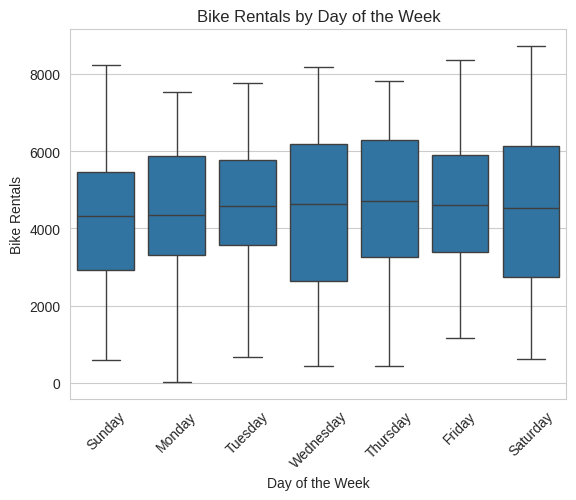

In [ ]:
# Define day names
day_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
             4: 'Thursday', 5: 'Friday', 6: 'Saturday'}

# Map weekday numbers to day names
data['day_name'] = data['weekday'].map(day_names)

# Create the boxplot with day names on the x-axis
sns.boxplot(x='day_name', y='cnt', data=data, order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title("Bike Rentals by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Bike Rentals")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


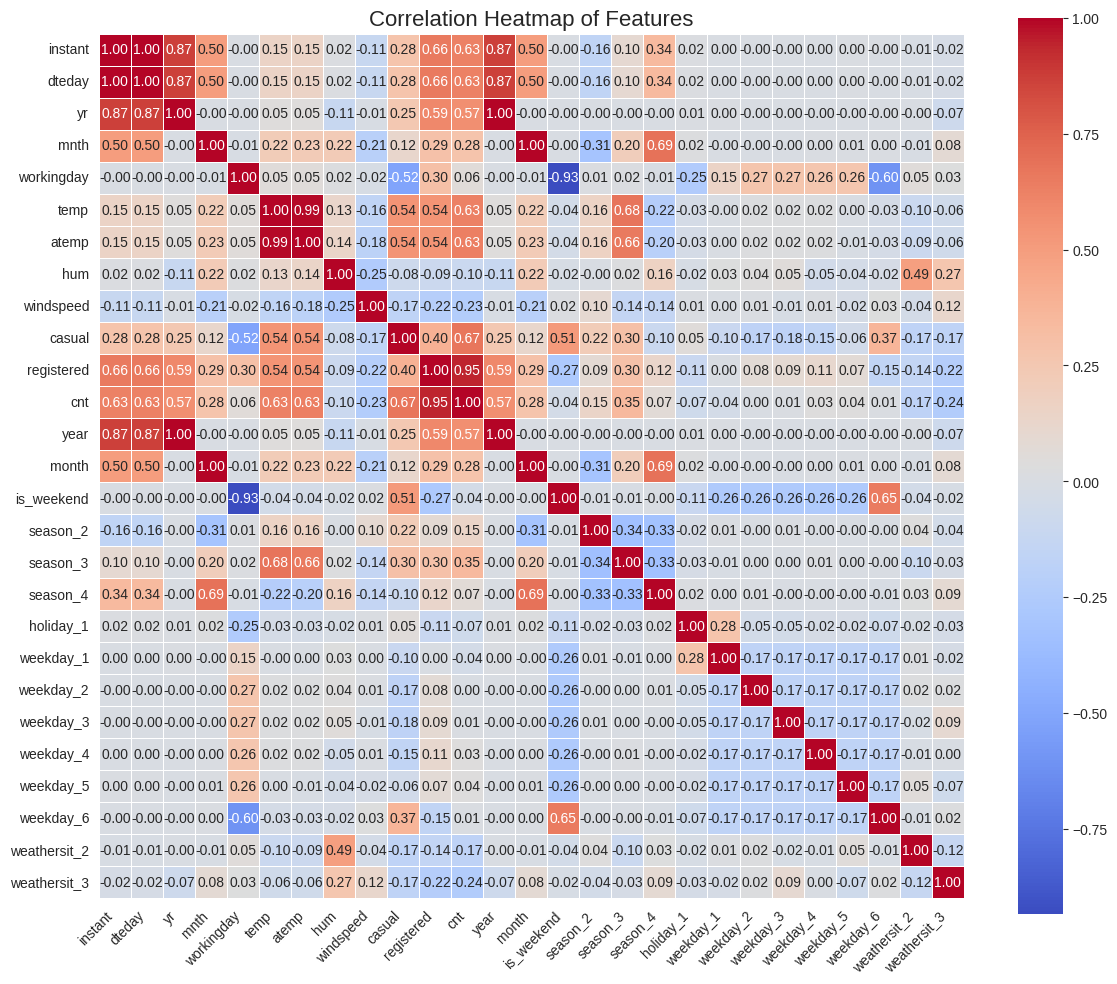

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size for better readability
correlation_matrix = data_encoded.corr()

# Plot heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, linewidths=0.5)

# Add title
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# Data Modelling

In [ ]:
# Also remove redundant features
X = data_encoded.drop(columns=[
    'cnt', 'instant', 'dteday', 'atemp',  # Remove redundant features
    'casual', 'registered',  # Remove direct contributors to target
    'year',  # Already have 'yr'
    'month'  # Already have 'mnth'
])
y = data_encoded['cnt']

# Calculate feature importance using mutual information
mutual_info = mutual_info_regression(X, y)
feature_importance = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Feature Importance:
temp            0.388830
mnth            0.378029
yr              0.279266
season_3        0.071110
windspeed       0.054996
hum             0.045483
weathersit_3    0.042695
season_4        0.034133
weekday_6       0.025967
weekday_3       0.023639
workingday      0.023526
weathersit_2    0.021345
weekday_4       0.017775
holiday_1       0.010544
weekday_1       0.004963
weekday_5       0.004021
season_2        0.003960
is_weekend      0.000000
weekday_2       0.000000
dtype: float64


In [ ]:
# Cross-validation for all models
def perform_cv(model, name, X, y):
    cv_rmse = -cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name} CV Results:")
    print(f"Mean RMSE: {cv_rmse.mean():.2f}")
    print(f"Std Dev RMSE: {cv_rmse.std():.2f}\n")

# Train both Linear
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_lr_pred = lr_model.predict(X_test)


In [ ]:

# Define the parameter grid
dt_param_grid = {
    'max_depth': range(1, 11),
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Perform Grid Search with 5-fold cross-validation
dt_grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=dt_param_grid,
    scoring='neg_root_mean_squared_error',  # Use RMSE as the scoring metric
    cv=5,
    n_jobs=-1  # Use all CPU cores
)
dt_grid_search.fit(X_train, y_train)

# Best parameters and score
best_dt_params = dt_grid_search.best_params_
best_dt_rmse = -dt_grid_search.best_score_
y_dt_pred = dt_grid_search.predict(X_test)

print("Best Decision Tree Parameters:", best_dt_params)
print(f"Best Decision Tree RMSE: {best_dt_rmse:.2f}")



Best Decision Tree Parameters: {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best Decision Tree RMSE: 906.16


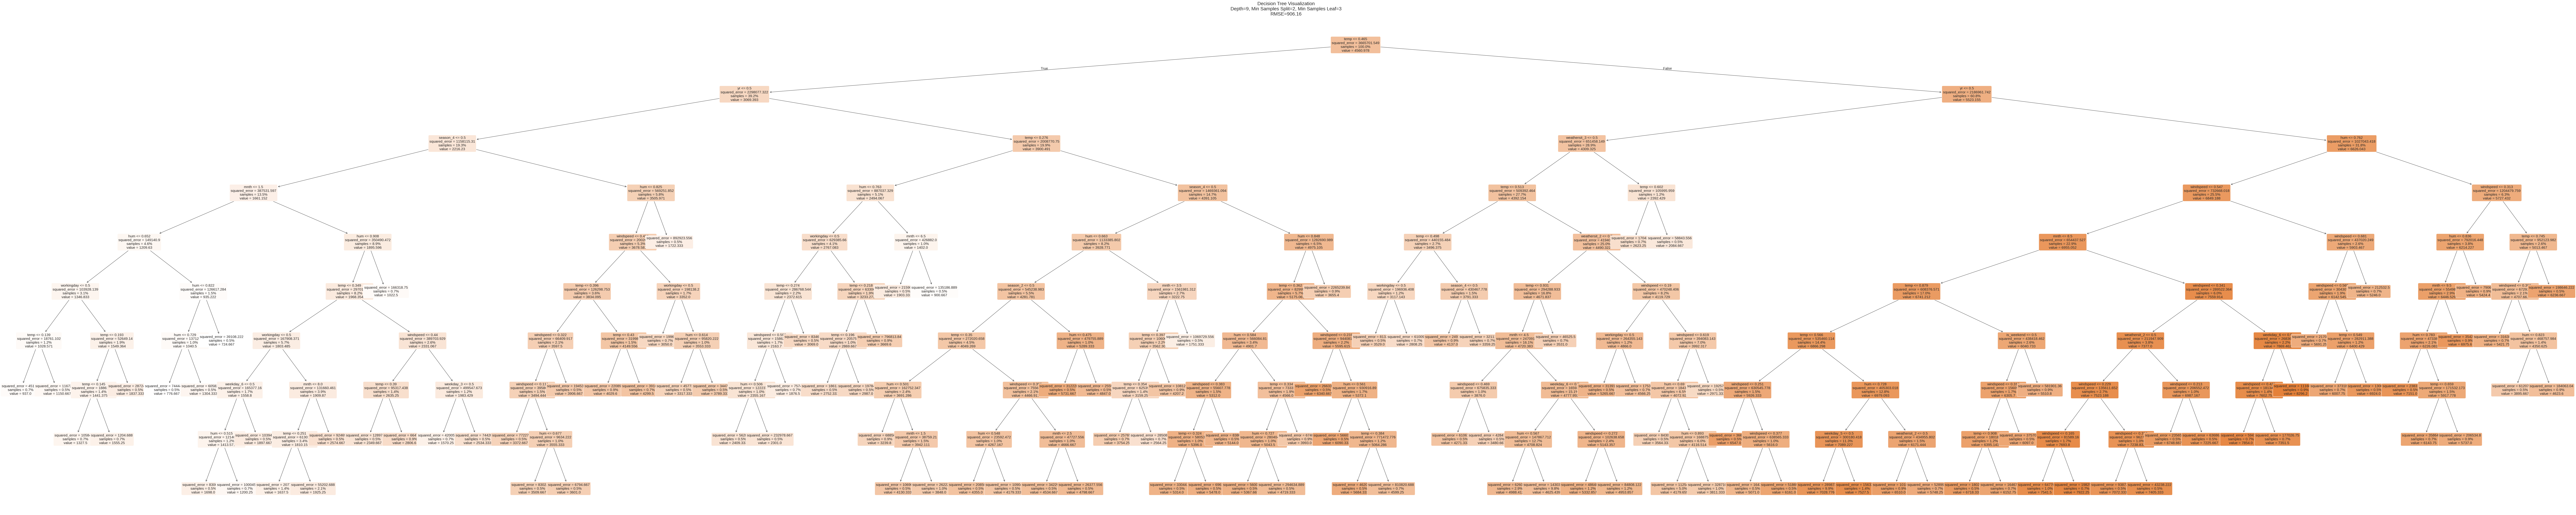

In [ ]:
# Get the best estimator from GridSearchCV
best_dt_model = dt_grid_search.best_estimator_

# Create a high-resolution figure for the tree visualization
plt.figure(figsize=(150, 30))
plot_tree(
    best_dt_model,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    fontsize=15,
    proportion=True
)

# Add a title with model details
plt.title(
    f"Decision Tree Visualization\n"
    f"Depth={best_dt_params['max_depth']}, "
    f"Min Samples Split={best_dt_params['min_samples_split']}, "
    f"Min Samples Leaf={best_dt_params['min_samples_leaf']}\n"
    f"RMSE={best_dt_rmse:.2f}",
    fontsize=20, pad=20
)

# Adjust layout and save
plt.tight_layout()
plt.savefig("decision_tree_high_res.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Define the parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)
rf_grid_search.fit(X_train, y_train)
y_rf_pred = rf_grid_search.predict(X_test)

# Best parameters and score
best_rf_params = rf_grid_search.best_params_
best_rf_rmse = -rf_grid_search.best_score_

print("Best Random Forest Parameters:", best_rf_params)
print(f"Best Random Forest RMSE: {best_rf_rmse:.2f}")


Best Random Forest Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest RMSE: 728.63


In [ ]:
# Define the parameter grid
ridge_param_grid = {
    'alpha': [0.1, 1.0, 10, 100]
}

# Perform Grid Search
ridge_grid_search = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=ridge_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)
ridge_grid_search.fit(X_train, y_train)
y_ridge_pred = ridge_grid_search.predict(X_test)

# Best parameters and score
best_ridge_params = ridge_grid_search.best_params_
best_ridge_rmse = -ridge_grid_search.best_score_

print("Best Ridge Parameters:", best_ridge_params)
print(f"Best Ridge RMSE: {best_ridge_rmse:.2f}")


Best Ridge Parameters: {'alpha': 0.1}
Best Ridge RMSE: 829.93


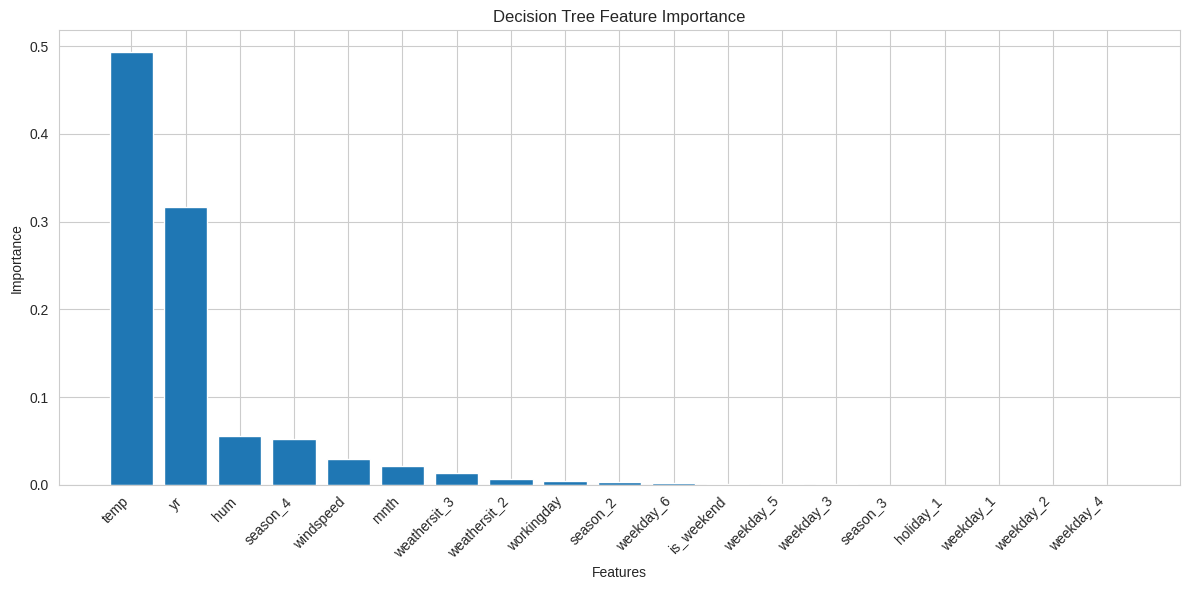

In [ ]:

# Create feature importance plot for Decision Tree
dt_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_dt_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(dt_feature_importance['feature'], dt_feature_importance['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Decision Tree Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


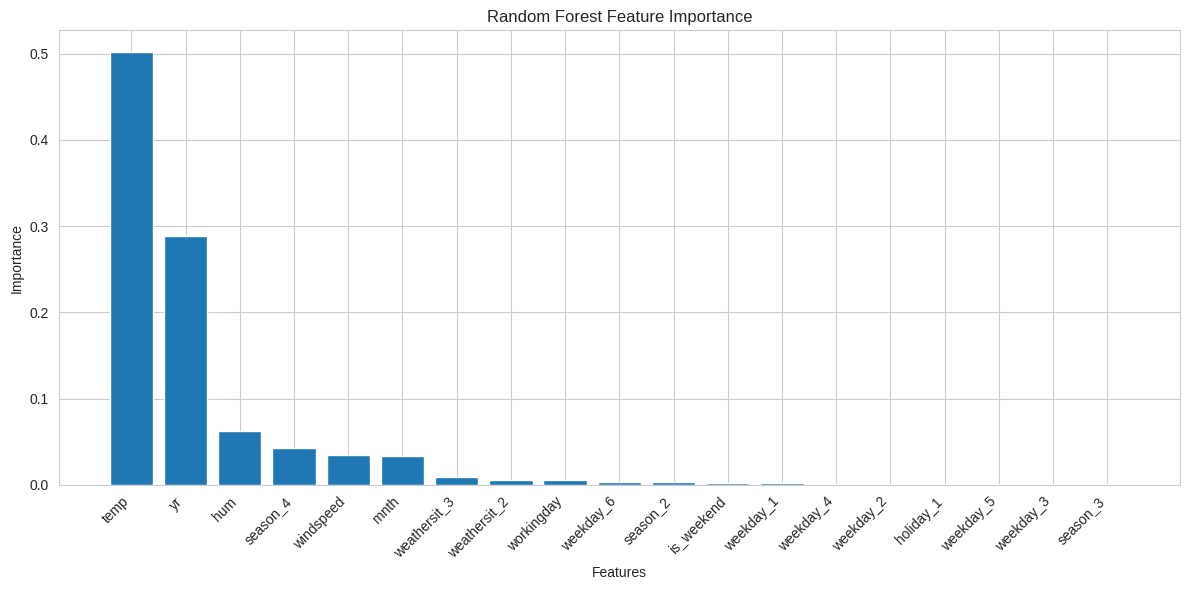

In [ ]:
# Access the best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

# Create a feature importance DataFrame
rf_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.bar(rf_feature_importance['feature'], rf_feature_importance['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Random Forest Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


In [ ]:
# Enhanced model evaluation function that returns metrics
def evaluate_model(name, y_test, y_pred):
    metrics = {}
    metrics['rmse'] = mean_squared_error(y_test, y_pred, squared=False)
    metrics['r2'] = r2_score(y_test, y_pred)
    metrics['mae'] = mean_absolute_error(y_test, y_pred)

    # Calculate adjusted R² (n = number of samples, p = number of features)
    n = len(y_test)
    p = X_test.shape[1]
    metrics['adj_r2'] = 1 - (1 - metrics['r2']) * (n - 1) / (n - p - 1)


    # Print results
    print(f"\n{name} Results:")
    print(f"RMSE: {metrics['rmse']:.2f}")
    print(f"R²: {metrics['r2']:.4f}")
    print(f"Adjusted R²: {metrics['adj_r2']:.4f}")
    print(f"MAE: {metrics['mae']:.2f}")

    return metrics

# Evaluate all models
print("\n=== Model Evaluation Results ===")
lr_metrics = evaluate_model("Linear Regression", y_test, y_lr_pred)
ridge_metrics = evaluate_model("Ridge Regression", y_test, y_ridge_pred)
rf_metrics = evaluate_model("Random Forest", y_test, y_rf_pred)
dt_metrics = evaluate_model("Decision Tree", y_test, y_dt_pred)

# Create summary DataFrame with all metrics
summary_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Random Forest', 'Decision Tree'],
    'Test RMSE': [lr_metrics['rmse'], ridge_metrics['rmse'], rf_metrics['rmse'], dt_metrics['rmse']],
    'Test R²': [lr_metrics['r2'], ridge_metrics['r2'], rf_metrics['r2'], dt_metrics['r2']],
    'Test MAE': [lr_metrics['mae'], ridge_metrics['mae'], rf_metrics['mae'], dt_metrics['mae']],
})

# Sort by RMSE (best performing first)
summary_df = summary_df.sort_values('Test RMSE')

# Print formatted summary table
print("\n=== Summary of All Models ===")
print(summary_df.round(4).to_string(index=False))

# Print best model details
best_model = summary_df.iloc[0]['Model']
print(f"\nBest Performing Model: {best_model}")
print(f"RMSE: {summary_df.iloc[0]['Test RMSE']:.2f}")
print(f"R²: {summary_df.iloc[0]['Test R²']:.4f}")
print(f"MAE: {summary_df.iloc[0]['Test MAE']:.2f}")



=== Model Evaluation Results ===

Linear Regression Results:
RMSE: 810.14
R²: 0.8363
Adjusted R²: 0.8118
MAE: 605.50

Ridge Regression Results:
RMSE: 810.23
R²: 0.8363
Adjusted R²: 0.8118
MAE: 605.89

Random Forest Results:
RMSE: 695.94
R²: 0.8792
Adjusted R²: 0.8611
MAE: 440.96

Decision Tree Results:
RMSE: 888.00
R²: 0.8034
Adjusted R²: 0.7739
MAE: 583.54

=== Summary of All Models ===
            Model  Test RMSE  Test R²  Test MAE
    Random Forest   695.9371   0.8792  440.9623
Linear Regression   810.1402   0.8363  605.4959
 Ridge Regression   810.2345   0.8363  605.8926
    Decision Tree   887.9972   0.8034  583.5448

Best Performing Model: Random Forest
RMSE: 695.94
R²: 0.8792
MAE: 440.96


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

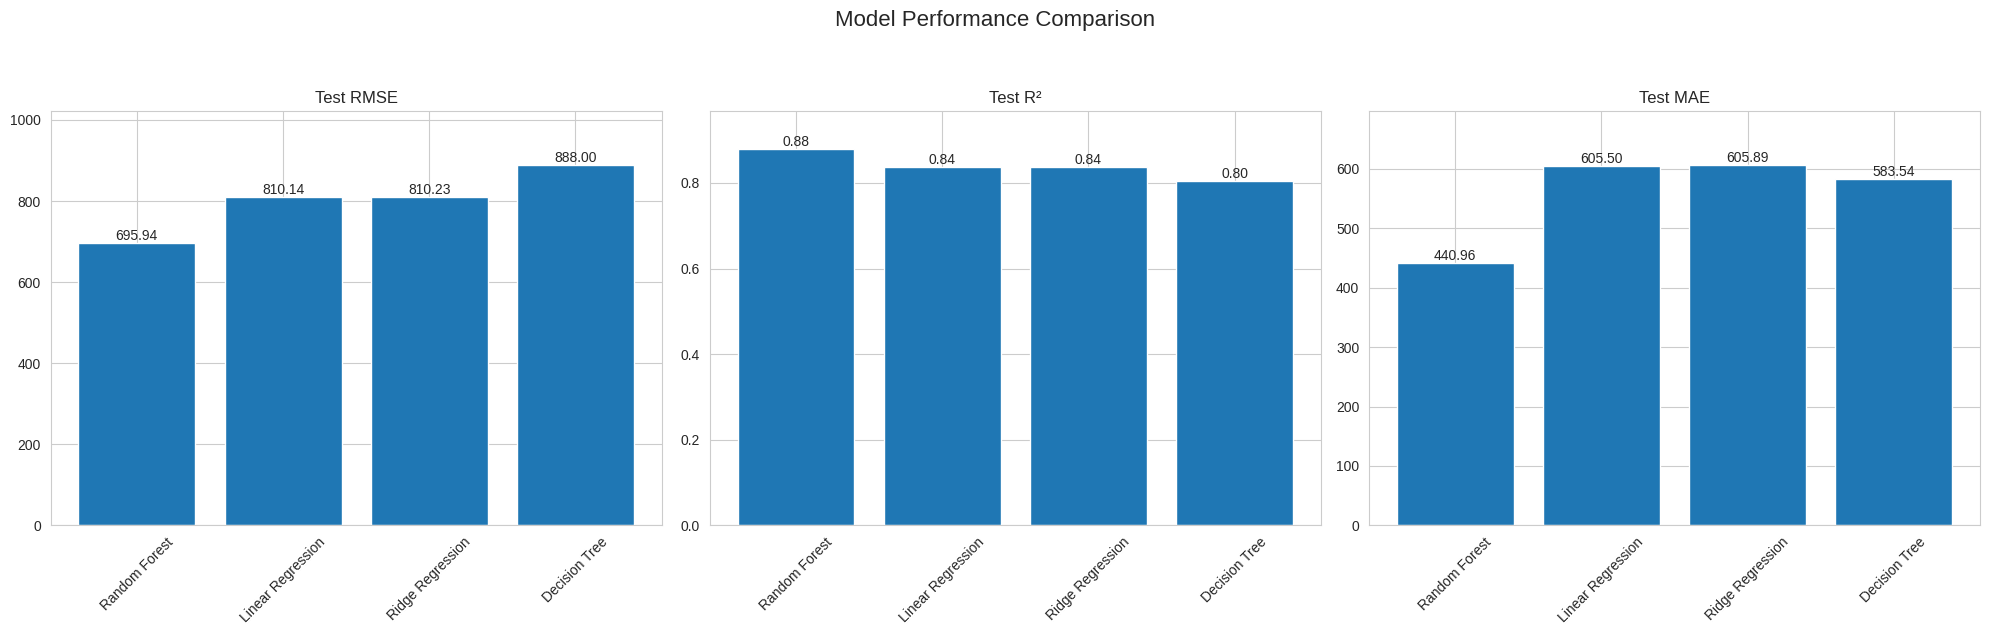

In [ ]:
# Visualize model performance comparison
metrics = ['Test RMSE', 'Test R²','Test MAE']  # Updated to match DataFrame column name
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.suptitle('Model Performance Comparison', size=16, y=1.05)

for i, metric in enumerate(metrics):
    # Create bar plot
    bars = axes[i].bar(summary_df['Model'], summary_df[metric])
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')

    # Adjust y-axis limits to make room for labels
    if metric == 'Test R²':
        axes[i].set_ylim(top=max(summary_df[metric]) * 1.1)
    else:
        axes[i].set_ylim(top=max(summary_df[metric]) * 1.15)

plt.tight_layout()
plt.show()


